In [2]:
import random
import math
import matplotlib.pyplot as plt

In [31]:
class AlgoritmoGenetico:
    def __init__(self, dimensoes: int, limite_min: float, limite_max: float ,tamanho_populacao: int, num_fitness: int, tipo_selecao: int, tipo_cruzamento: int ,taxa_de_cruzamento: float, taxa_de_mutacao: float, qtd_geracoes:int):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.tamanho_populacao = tamanho_populacao
        self.tipo_selecao = tipo_selecao
        self.num_fitness = num_fitness
        self.tipo_cruzamento = tipo_cruzamento
        self.taxa_de_cruzamento = taxa_de_cruzamento
        self.taxa_de_mutacao = taxa_de_mutacao
        self.qtd_geracoes = qtd_geracoes

        self.melhor_individuo = []
        self.best_fitness = 0

    def gerar_individuo(self):
        return [random.uniform(self.limite_min, self.limite_max) for i in range(self.dimensoes)]
    
    def gerar_populacao(self):
        return [self.gerar_individuo() for i in range(self.tamanho_populacao )]
    
    def sphere(self,individuo):
        resultado = 0
        for i in individuo:
            resultado += i ** 2
        return resultado
    
    def rastrigin(self,individuo):
        resultado = 0
        for i in individuo:
            numero = 2*3.1415*i
            p = (numero/180)*math.pi
            resultado+= (i**2) - (10 * math.cos(p)) + 10    
        return resultado
    
    def rosenbrock(self,individuo):
        resultado = 0
        for i in range(0,(len(individuo)-1)):
            resultado += 100*(individuo[i+1] - individuo[i]**2)**2 + (individuo[i] - 1)**2   
        return resultado

    def avaliar_populacao(self, populacao):
        funcao_fitness = (self.sphere if self.num_fitness == 1 
                        else self.rastrigin if self.num_fitness == 2
                        else self.rosenbrock  if self.num_fitness == 3
                        else self.sphere)
        avaliacao = []
        for individuo in populacao:
            avaliacao.append(funcao_fitness(individuo))
        return avaliacao

    def selecao_proporcional_fitness(self, populacao, avaliacao):
        lista_fitness_minimo = [1 / resultado for resultado in avaliacao]

        total_fitness_minimo = sum(lista_fitness_minimo)

        probabilidades = [valor/total_fitness_minimo for valor in lista_fitness_minimo]
        pais = random.choices(populacao, weights=probabilidades, k=self.tamanho_populacao)

        return pais

    def selecao_torneio(self, populacao, avaliacao):
        pais_vencedores = []

        for i in range(len(populacao)):
            participantes = random.sample(range(len(populacao)), 2)
            
            if avaliacao[participantes[0]] < avaliacao[participantes[1]]:
                vencedor = participantes[0]
            else:
                vencedor = participantes[1]
            
            pais_vencedores.append(populacao[vencedor])

        return pais_vencedores

    def cruzamento_1_ponto(self, pai1, pai2):
        num_random = random.random()
        if num_random <= self.taxa_de_cruzamento:
            posicao = random.randint(1, len(pai1) - 1)
            filho1 = pai1[:posicao] + pai2[posicao:]
            filho2 = pai2[:posicao] + pai1[posicao:]
            return [filho1, filho2]
        else:
            return [pai1, pai2]

    def cruzamento_2_ponto(self,pai1, pai2):
        num_random = random.random()
        if num_random <= self.taxa_de_cruzamento:
            num1 = random.randint(1, len(pai1) - 1)
            num2 = random.randint(1, len(pai1) - 1)

            while num1 == num2:
                num2 = random.randint(1, len(pai1) - 1)

            posicao = num1 if num1 < num2 else num2
            posicao2 = num2 if num1 < num2 else num1

            filho1 = pai1[:posicao] + pai2[posicao:posicao2] + pai1[posicao2:]
            filho2 = pai2[:posicao] + pai1[posicao:posicao2] + pai2[posicao2:]

            return [filho1, filho2]
        else:
            return [pai1, pai2]
    
    def cruzamento(self, pais, tipo_cruzamento):
        filhos = []

        if len(pais) % 2 == 0:
            for i in range(0, len(pais), 2):
                resultado_cruzamento = tipo_cruzamento(pais[i], pais[i+1])
                filhos.append(resultado_cruzamento[0])
                filhos.append(resultado_cruzamento[1])
        else:
            for i in range(0, len(pais) - 1, 2):
                resultado_cruzamento = tipo_cruzamento(pais[i], pais[i+1])
                filhos.append(resultado_cruzamento[0])
                filhos.append(resultado_cruzamento[1])
        
            resultado_cruzamento = tipo_cruzamento(pais[0], pais[-1])
            filhos.append(resultado_cruzamento[0])
            # filhos.append(resultado_cruzamento[1])

        return filhos

    def mutacao(self, filhos):
        for filho in filhos:
            for gene in range(0, len(filho)):
                num = random.random()
                if num <= self.taxa_de_mutacao:
                    filho[gene] = random.uniform(self.limite_min, self.limite_max)

        return filhos

    def executar(self):
        populacao = self.gerar_populacao()
        melhores_fitness = []

        tipo_cruzamento = (self.cruzamento_1_ponto if self.tipo_cruzamento == 1 
                           else self.cruzamento_2_ponto)

        selecao = (self.selecao_proporcional_fitness if self.tipo_selecao == 1 
                   else self.selecao_torneio)

        for geracao in range(self.qtd_geracoes):
            avaliacao = self.avaliar_populacao(populacao)
            selecao_pais = selecao(populacao, avaliacao)
            cruzamento_filhos = self.cruzamento(selecao_pais, tipo_cruzamento)
            populacao = self.mutacao(cruzamento_filhos)

            nova_avaliacao = self.avaliar_populacao(populacao)
            self.best_fitness = min(nova_avaliacao)
            self.melhor_individuo = populacao[nova_avaliacao.index(self.best_fitness)]
            melhores_fitness.append(self.best_fitness)

        return melhores_fitness
    
    def exibir_melhor_individuo(self):
        print(f"Geração {self.qtd_geracoes}: Melhor Fitness = {self.best_fitness}, Indivíduo = {self.melhor_individuo}")

### Execução do AG - Sphere

Geração 1500: Melhor Fitness = 69.03380104145559, Indivíduo = [1.7078176507643974, 0.8152982090338554, -3.065766299496005, -1.3727933774059835, 0.1873126167925676, -1.001474616030535, 0.6308533329742829, -0.2814682624485698, -0.010945584509556738, 3.150785534161642, -1.1297126548708007, 0.5311536018534753, 2.5127941257434827, -0.2991172981086976, -1.3137772784783834, 2.638708107039477, -4.794069343218595, 1.4147987041367855, -0.0006287110092557668, 1.0443317989877556]


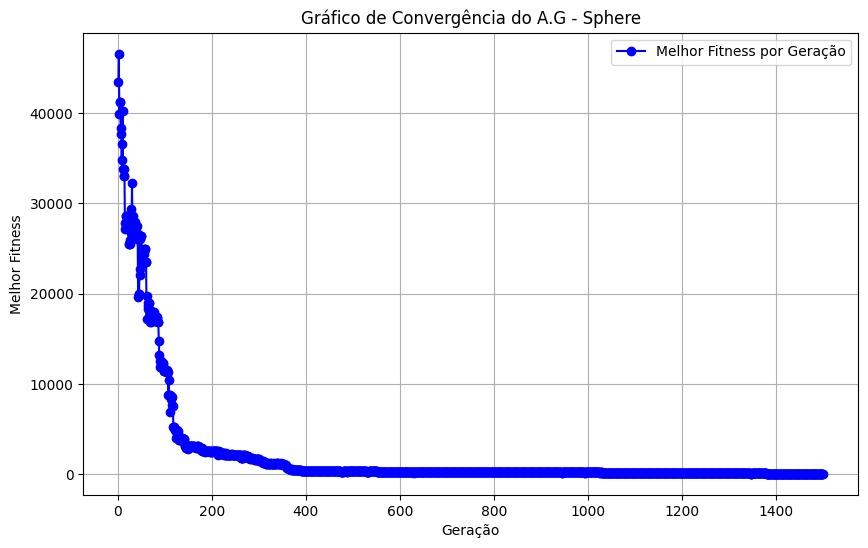

In [28]:
alg = AlgoritmoGenetico(dimensoes= 20, 
                        limite_min= -100.0,
                        limite_max= 100.0,
                        tamanho_populacao= 30, 
                        tipo_selecao= 1, # 1 = Proporcional ao Fitness   # 2 = Torneio
                        num_fitness= 1,  # 1 = Sphere   2 = Rastrigin  3 = rosenbrock
                        tipo_cruzamento= 1,  # 1 = Cruzamento por 1 ponto     2 = Cruzamento por 2 pontos
                        taxa_de_cruzamento= 0.9, 
                        taxa_de_mutacao= 0.01,
                        qtd_geracoes= 1500)

best_fitness = alg.executar()
alg.exibir_melhor_individuo()

x = [i for i in range(1, len(best_fitness) + 1)]
y = best_fitness

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness por Geração')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência do A.G - Sphere')
plt.legend()
plt.grid(True)
plt.show()

### Execução do AG - Rastrigin

Geração 1500: Melhor Fitness = 23.490258198549387, Indivíduo = [-0.2671284079800209, -0.2095758231784366, 1.5019599405613278, 0.38460693472828567, 0.4007729841333365, -0.44298076513705453, -0.3492125132739261, 0.955219013629339, -1.1172822298425942, 0.6822071415014079, -1.9114864183690123, 1.3721829033095396, -1.0551894754127638, -0.28363070141024593, -0.8222665065980799, -1.8954834983999014, 1.5559606583024888, -0.977355189544042, 0.13558937437424134, -1.4637895373595633]


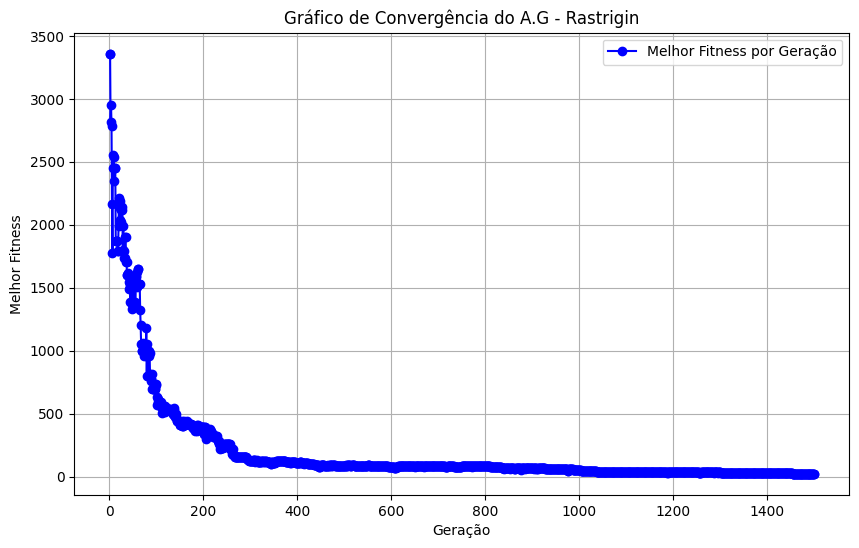

In [10]:
alg = AlgoritmoGenetico(dimensoes= 20, 
                        limite_min= -30.0,
                        limite_max= 30.0,
                        tamanho_populacao= 30, 
                        tipo_selecao= 1, # 1 = Proporcional ao Fitness   # 2 = Torneio
                        num_fitness= 2,  # 1 = Sphere   2 = Rastrigin  3 = rosenbrock
                        tipo_cruzamento= 1,  # 1 = Cruzamento por 1 ponto     2 = Cruzamento por 2 pontos
                        taxa_de_cruzamento= 0.9, 
                        taxa_de_mutacao= 0.01,
                        qtd_geracoes= 1500)

best_fitness = alg.executar()
alg.exibir_melhor_individuo()

x = [i for i in range(1, len(best_fitness) + 1)]
y = best_fitness

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness por Geração')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência do A.G - Rastrigin')
plt.legend()
plt.grid(True)
plt.show()

### Execução do AG - Rosenbrock

Geração 1500: Melhor Fitness = 215.48181702380057, Indivíduo = [-0.2773992128872962, -0.053697109896965856, 0.07843527675878459, 0.4717039800636158, 0.8330781738368254, 1.0789705217057701, 0.7881390239143995, 0.4361803338722412, 0.037023900357107564, 0.24666056448696239, 0.5082892339832403, 0.6556877064467486, 0.7839597615875, 0.7380171813729071, 0.47106530239344835, 0.5846464747209161, 0.4896686284433587, 0.829126970485734, 0.8228382032096873, 0.8813998851726277]


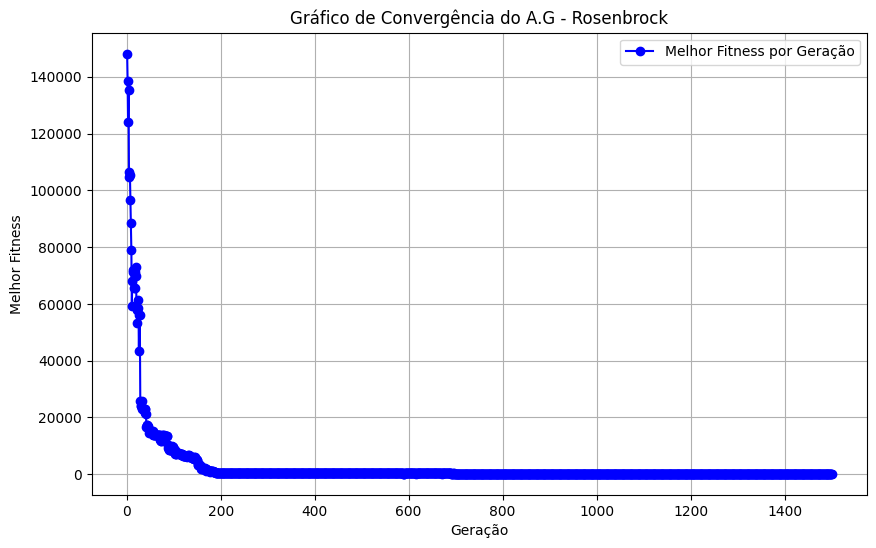

In [17]:
alg = AlgoritmoGenetico(dimensoes= 20, 
                        limite_min= -5.12,
                        limite_max= 5.12,
                        tamanho_populacao= 30, 
                        tipo_selecao= 1, # 1 = Proporcional ao Fitness   # 2 = Torneio
                        num_fitness= 3,  # 1 = Sphere   2 = Rastrigin  3 = rosenbrock
                        tipo_cruzamento= 1,  # 1 = Cruzamento por 1 ponto     2 = Cruzamento por 2 pontos
                        taxa_de_cruzamento= 0.9, 
                        taxa_de_mutacao= 0.01,
                        qtd_geracoes= 1500)

best_fitness = alg.executar()
alg.exibir_melhor_individuo()

x = [i for i in range(1, len(best_fitness) + 1)]
y = best_fitness

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness por Geração')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência do A.G - Rosenbrock')
plt.legend()
plt.grid(True)
plt.show()

### Gráfico de convergência AG - SPHERE

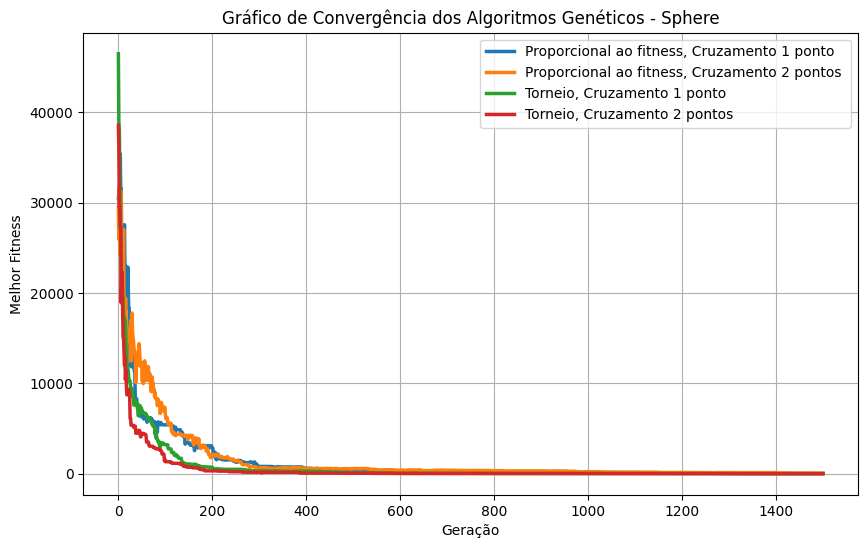

In [56]:
alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 1, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness1 = alg.executar()


alg2 = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 1, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness2 = alg2.executar()


alg3 = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 1, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness3 = alg3.executar()


alg4 = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 1, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness4 = alg4.executar()


colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 6))
plt.plot(best_fitness1, label='Proporcional ao fitness, Cruzamento 1 ponto', color=colors(0), linewidth=2.5)
plt.plot(best_fitness2, label='Proporcional ao fitness, Cruzamento 2 pontos ', color=colors(1), linewidth=2.5)
plt.plot(best_fitness3, label='Torneio, Cruzamento 1 ponto', color=colors(2), linewidth=2.5)
plt.plot(best_fitness4, label='Torneio, Cruzamento 2 pontos', color=colors(3), linewidth=2.5)

plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência dos Algoritmos Genéticos - Sphere')
plt.legend()
plt.grid(True)
plt.show()

### Gráfico de convergência AG - Rastrigin

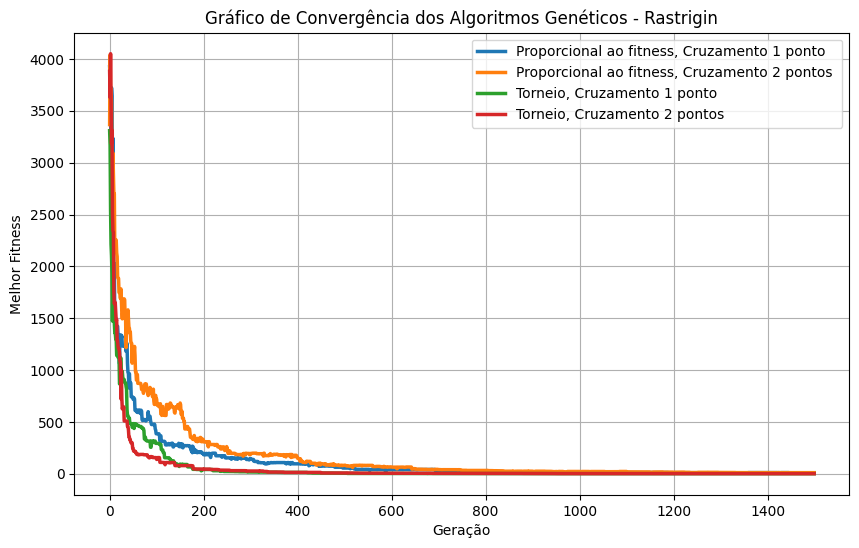

In [54]:
alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 2, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness1 = alg.executar()


alg2 = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 2, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness2 = alg2.executar()


alg3 = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 2, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness3 = alg3.executar()


alg4 = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 2, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness4 = alg4.executar()


colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 6))
plt.plot(best_fitness1, label='Proporcional ao fitness, Cruzamento 1 ponto', color=colors(0), linewidth=2.5)
plt.plot(best_fitness2, label='Proporcional ao fitness, Cruzamento 2 pontos ', color=colors(1), linewidth=2.5)
plt.plot(best_fitness3, label='Torneio, Cruzamento 1 ponto', color=colors(2), linewidth=2.5)
plt.plot(best_fitness4, label='Torneio, Cruzamento 2 pontos', color=colors(3), linewidth=2.5)

plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência dos Algoritmos Genéticos - Rastrigin')
plt.legend()
plt.grid(True)
plt.show()

### Gráfico de convergência AG - Rosenbrock

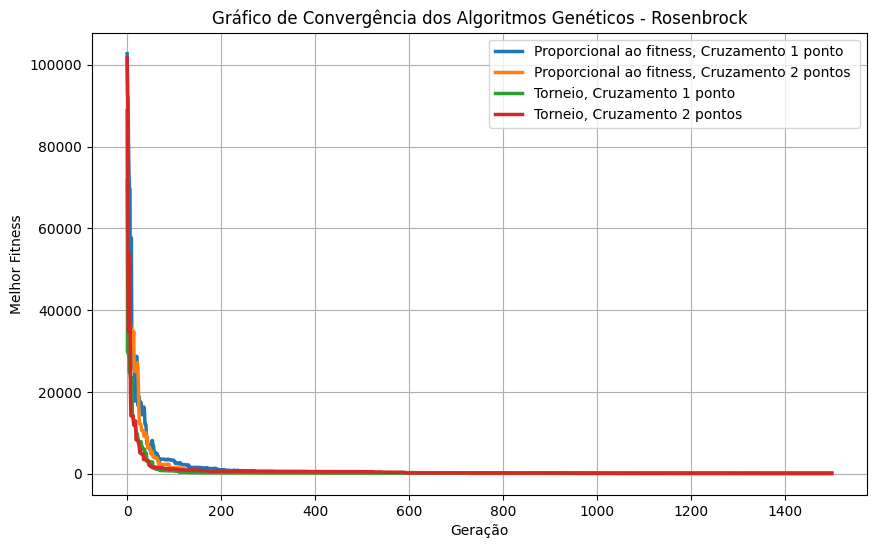

In [53]:
alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 3, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness1 = alg.executar()


alg2 = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 3, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness2 = alg2.executar()


alg3 = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 3, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness3 = alg3.executar()


alg4 = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 3, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
best_fitness4 = alg4.executar()

colors = plt.get_cmap("tab10")
plt.figure(figsize=(10, 6))
plt.plot(best_fitness1, label='Proporcional ao fitness, Cruzamento 1 ponto', color=colors(0), linewidth=2.5)
plt.plot(best_fitness2, label='Proporcional ao fitness, Cruzamento 2 pontos ', color=colors(1), linewidth=2.5)
plt.plot(best_fitness3, label='Torneio, Cruzamento 1 ponto', color=colors(2), linewidth=2.5)
plt.plot(best_fitness4, label='Torneio, Cruzamento 2 pontos', color=colors(3), linewidth=2.5)

plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.title('Gráfico de Convergência dos Algoritmos Genéticos - Rosenbrock')
plt.legend()
plt.grid(True)
plt.show()

## Cenários de testes
Execução de diversos cenários de testes, alternando: 
- Função fitness
- Tipo de seleção
- Tipo de cruzamento

Esses cenários tem como objetivo exibir uma comparação dos valores gerados através de um Gráfico Boxplot.

### Cenário com Função fitness: Sphere

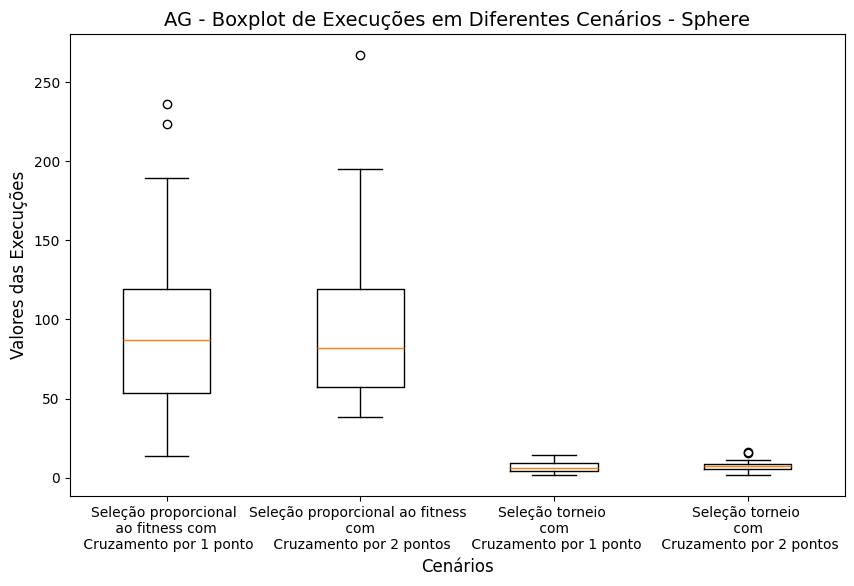

In [36]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 1, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_1.append(alg.best_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 1, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_2.append(alg.best_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 1, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_3.append(alg.best_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -100.0, limite_max= 100.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 1, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_4.append(alg.best_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Seleção proporcional \n ao fitness com \n Cruzamento por 1 ponto', 'Seleção proporcional ao fitness \n com \n Cruzamento por 2 pontos', 'Seleção torneio \n com \n Cruzamento por 1 ponto', 'Seleção torneio \n com \n Cruzamento por 2 pontos'])

plt.title('AG - Boxplot de Execuções em Diferentes Cenários - Sphere', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Cenário com Função fitness: Rastrigin

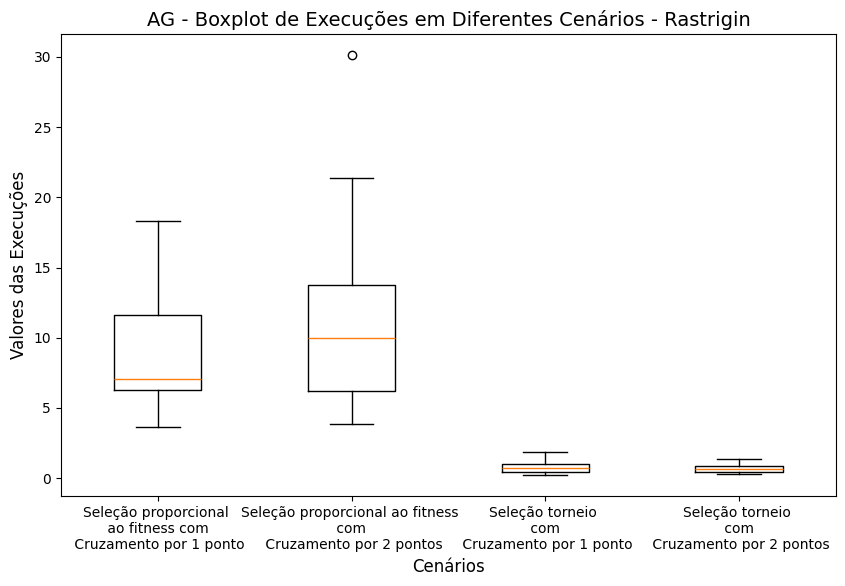

In [37]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 2, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_1.append(alg.best_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 2, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_2.append(alg.best_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 2, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_3.append(alg.best_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -30.0, limite_max= 30.0, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 2, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_4.append(alg.best_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Seleção proporcional \n ao fitness com \n Cruzamento por 1 ponto', 'Seleção proporcional ao fitness \n com \n Cruzamento por 2 pontos', 'Seleção torneio \n com \n Cruzamento por 1 ponto', 'Seleção torneio \n com \n Cruzamento por 2 pontos'])

plt.title('AG - Boxplot de Execuções em Diferentes Cenários - Rastrigin', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Cenário com Função fitness: Rosenbrock

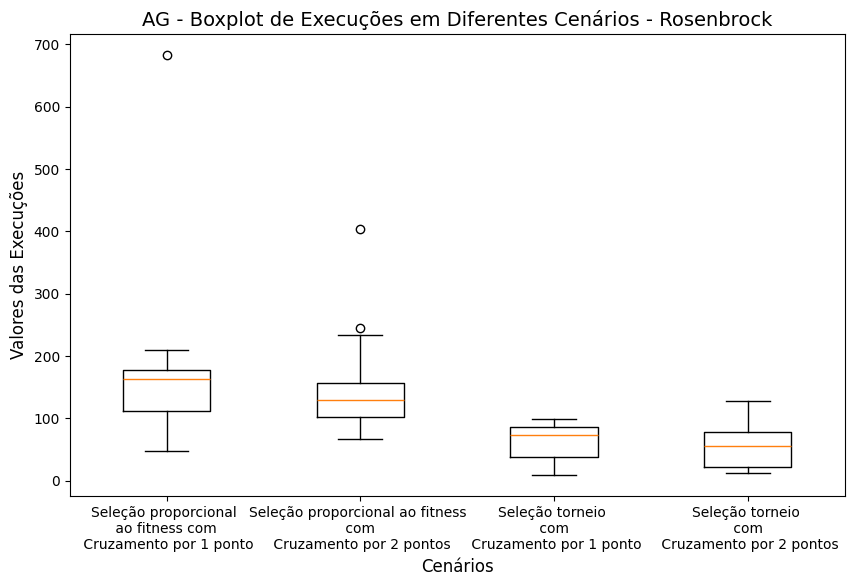

In [38]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 3, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_1.append(alg.best_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 1,
                            num_fitness= 3, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_2.append(alg.best_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 3, tipo_cruzamento= 1,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_3.append(alg.best_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoGenetico(dimensoes= 20, limite_min= -5.12, limite_max= 5.12, tamanho_populacao= 30,  tipo_selecao= 2,
                            num_fitness= 3, tipo_cruzamento= 2,  taxa_de_cruzamento= 0.9, taxa_de_mutacao= 0.01, qtd_geracoes= 1500)
    alg.executar()
    cenario_4.append(alg.best_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Seleção proporcional \n ao fitness com \n Cruzamento por 1 ponto', 'Seleção proporcional ao fitness \n com \n Cruzamento por 2 pontos', 'Seleção torneio \n com \n Cruzamento por 1 ponto', 'Seleção torneio \n com \n Cruzamento por 2 pontos'])

plt.title('AG - Boxplot de Execuções em Diferentes Cenários - Rosenbrock', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()